# Data Collection
The data were scraped using [Health Canada - Drug Product Database (DPD) API](https://health-products.canada.ca/api/documentation/dpd-documentation-en.html#a4.4). A total of 4 dataframes - `Drug Product`, `Current Status`, `Schedule` and `Therapeutic Class` - will be used for this data analysis project. The terminology definitions can be found on [Health Canada Drug Product Database Terminology](https://www.canada.ca/en/health-canada/services/drugs-health-products/drug-products/drug-product-database/terminology.html) to better understand the dataframes. 

To better interpret `tc_atc_number` (Anatomical Therapeutic Chemical Number) from `Therapeutic Class`. ATC group name to third level (first 3 digit) were scraped from [Norweguab Institute of Public Heath](https://atcddd.fhi.no/atc_ddd_index/).

In [1]:
# Standard imports
import pandas as pd
import numpy as np

# For web scraping
import requests
from bs4 import BeautifulSoup

# Visualziation
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\yelin\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\yelin\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Scrape Drug Product
url = 'https://health-products.canada.ca/api/drug/drugproduct/?lang=en&type=json'
res = requests.get(url)
drug_product = pd.DataFrame(res.json())
drug_product[drug_product['drug_code']==2037]

# drug_product.to_csv('Drug Product.csv')

,drug_code,class_name,drug_identification_number,brand_name,descriptor,number_of_ais,ai_group_no,company_name,last_update_date
2049,2037,Human,00313580,DIAZEPAM 5 TAB,,1,0103614001,PRO DOC LIMITEE,2017-12-20


In [3]:
# Scraping Status
url = 'https://health-products.canada.ca/api/drug/status/?lang=en&type=json'
res = requests.get(url)
drug_status= pd.DataFrame(res.json())
drug_status[drug_status['drug_code']==2037]

# drug_status.to_csv('Drug Status.csv')

,drug_code,status,history_date,original_market_date,external_status_code,expiration_date,lot_number
18412,2037,Cancelled Post Market,2017-05-05,1974-12-31,4,2020-02-29,15-0150


In [4]:
# Scrape Drug Schedule
url = 'https://health-products.canada.ca/api/drug/schedule/?lang=en&type=json'
res = requests.get(url)
drug_schedule = pd.DataFrame(res.json())
drug_schedule[drug_schedule['drug_code'] == 2037]

# drug_schedule.to_csv('Drug Schedule.csv')

,drug_code,schedule_name
37673,2037,Targeted (CDSA IV)


In [5]:
# Scraping Therapeutic Class
url = 'https://health-products.canada.ca/api/drug/therapeuticclass/?lang=en&type=json'
res = requests.get(url)
drug_atc = pd.DataFrame(res.json())
drug_atc[drug_atc['drug_code']==2037]

# drug_atc.to_csv('Drug Therapeutic Class.csv')

,drug_code,tc_atc_number,tc_atc,tc_ahfs_number,tc_ahfs
4633,2037,N05BA01,DIAZEPAM,,


In [6]:
# Scraping atc name
def scraping(url):
    res = requests.get(url)
    soup = BeautifulSoup(res.content, 'html.parser')
    items = soup.select('#content_padding')[0].find_all('a', href=True)
    atc_data = []
    for item in items:
        href = item['href']
        text = item.get_text(strip=True)
        if 'code=' in href:
            atc_code = href.split('code=')[1].split('&')[0]
            atc_data.append({'Code': atc_code, 'Description': text})
    
    return pd.DataFrame(atc_data)

first = ['A', 'B', 'C', 'D', 'G', 'H','J','L','M','N','P','R','S','V']
df_lst = []
for group in first:
    url = f'https://atcddd.fhi.no/atc_ddd_index/?code={group}&showdescription=no'
    df_lst.append(scraping(url))
full_atc = pd.concat(df_lst).reset_index(drop=True)

to_drop = full_atc[full_atc['Description']=='Show text from Guidelines'].index # Drop redundencies
full_atc = full_atc.drop(to_drop).reset_index(drop=True)
full_atc[full_atc['Code'].isin(first)]

# full_atc.to_csv('atc code.csv')

,Code,Description
0,A,ALIMENTARY TRACT AND METABOLISM
17,B,BLOOD AND BLOOD FORMING ORGANS
23,C,CARDIOVASCULAR SYSTEM
33,D,DERMATOLOGICALS
45,G,GENITO URINARY SYSTEM AND SEX HORMONES
50,H,"SYSTEMIC HORMONAL PREPARATIONS, EXCL. SEX HORM..."
56,J,ANTIINFECTIVES FOR SYSTEMIC USE
63,L,ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS
68,M,MUSCULO-SKELETAL SYSTEM
75,N,NERVOUS SYSTEM


# Data Cleaning and Preparation

## Drug Status

In [7]:
drug_status = pd.read_csv('Drug Status.csv').drop(columns = ['Unnamed: 0'])
drug_status.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56459 entries, 0 to 56458
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   drug_code             56459 non-null  int64 
 1   status                56459 non-null  object
 2   history_date          56459 non-null  object
 3   original_market_date  47975 non-null  object
 4   external_status_code  56459 non-null  int64 
 5   expiration_date       4975 non-null   object
 6   lot_number            4996 non-null   object
dtypes: int64(2), object(5)
memory usage: 3.0+ MB


In [8]:
# Correct data type in history_date and original_market_date

drug_status['history_date'] = pd.to_datetime(drug_status['history_date'],format = '%Y-%m-%d')
drug_status['original_market_date'] = pd.to_datetime(drug_status['original_market_date'],format = '%Y-%m-%d')

# Drop expiration_date and lot_number -> they will not be further analyzed
drug_status.drop(columns = ['expiration_date', 'lot_number', 'external_status_code'], inplace=True)

There are 11 unique drug status which can be roughly grouped into 4 categories:
1. Currently Marketed: Marketed, Restricted Access
2. Cancelled Post market: Cancelled Post Market, Cancelled (Safety Issue), Cancelled (Unreturned Annual)
3. Cancelled Pre market: Cancelled Pre Market, Authorized By Interim Order Revoked, Authorized By Interim Order Expired
4. Under Review: Approved, Authorized By Interim Order, Dormant

Please refer to [Health Canada Drug Product Database Terminology](https://www.canada.ca/en/health-canada/services/drugs-health-products/drug-products/drug-product-database/terminology.html) to better the reason for the grouping.

In [9]:
def replace_status(status):
    market = ['Marketed', 'Restricted Access']
    c_post = ['Cancelled Post Market', 'Cancelled (Safety Issue)', 'Cancelled (Unreturned Annual)']
    c_pre = ['Cancelled Pre Market', 'Authorization By Interim Order Revoked', 'Authorization By Interim Order Expired']
    review = ['Approved', 'Authorization by Interim Order', 'Dormant']

    if status in market:
        return 'Currently Marketed'
    elif status in c_post:
        return 'Cancelled Post Market'
    elif status in c_pre:
        return 'Cancelled Pre Market'
    elif status in review:
        return 'Under Review'
    else:
        return None
    
drug_status['status_grouped'] = drug_status['status'].apply(replace_status)
drug_status['status_grouped'].isna().sum() # Pass
drug_status['status_grouped'].value_counts()

status_grouped
Cancelled Post Market    33010
Currently Marketed       13097
Under Review              6922
Cancelled Pre Market      3430
Name: count, dtype: int64

In [10]:
drug_status['original_market_date'].isna().sum()

8484

Please note that all drugs labelled `Under Review` and `Cancelled Pre Market` are expected to not to have an original market date. However, this is found not to be true. After investigating the dataframe further, it is found that whether or not original market date is missing is not really predictable by looking at the `status` However, this categorization is mostly true as most of the drugs in `Cancelled Post Market` and `Curerntly Marketed` has an original market date, and most of the rest do not. See visualization below. 

When showing the visualization on Tableau, all drugs with missing original market date will be considered as if they were never put on market. 

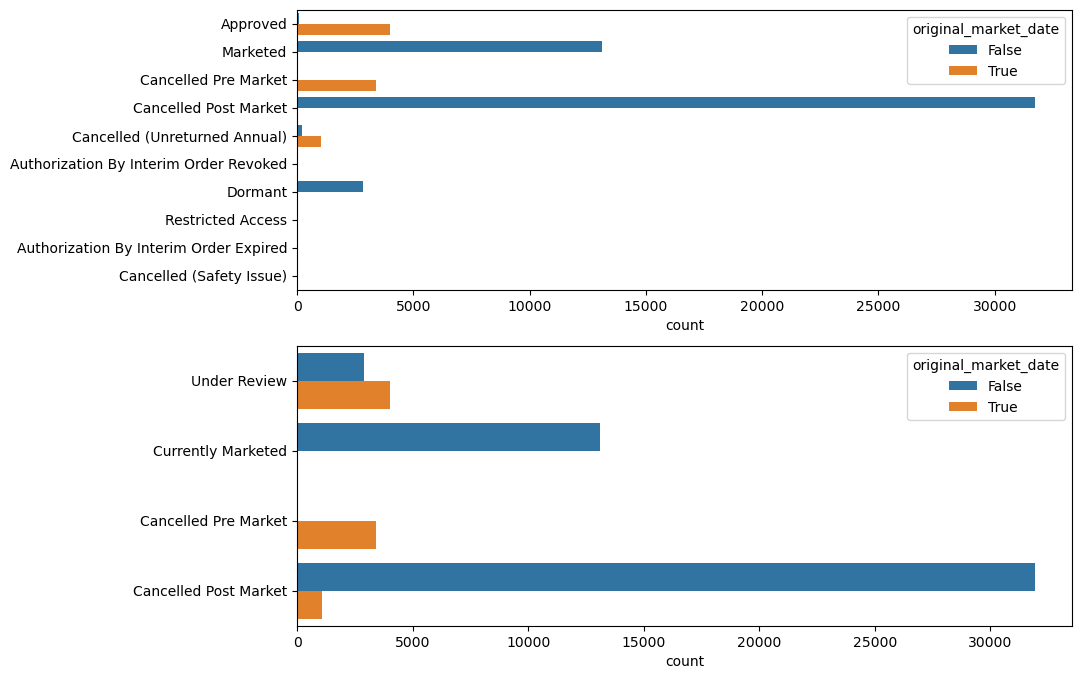

In [11]:
fig1, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (10,8))
sns.countplot(data=drug_status, y='status', 
              hue = (drug_status['original_market_date'].isna()), 
              stat='count', 
              ax=ax1)

ax1.set_ylabel('')

sns.countplot(data=drug_status, y='status_grouped', 
              hue = (drug_status['original_market_date'].isna()), 
              stat='count', 
              ax=ax2)

ax2.set_ylabel('');

In [12]:
# With that, status will be dropped
drug_status.drop(columns = 'status', inplace=True)

## Drug Product

In [13]:
drug_product = pd.read_csv('Drug Product.csv').drop(columns = ['Unnamed: 0'])
drug_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56459 entries, 0 to 56458
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   drug_code                   56459 non-null  int64 
 1   class_name                  56459 non-null  object
 2   drug_identification_number  56459 non-null  int64 
 3   brand_name                  56459 non-null  object
 4   descriptor                  3199 non-null   object
 5   number_of_ais               56459 non-null  int64 
 6   ai_group_no                 56459 non-null  int64 
 7   company_name                56459 non-null  object
 8   last_update_date            56459 non-null  object
dtypes: int64(4), object(5)
memory usage: 3.9+ MB


The following columns will be dropped:

1. `descriptor`: contains information about drug formulation, will not be analyzed
2. `last_update_date`: `last_update_date` is updated anytime when certain key fields are changed while `history_date` in drug_status is associated with drug's status. In this case, `history_date` will be used as the project focused more on drug status rather than drug formulation. 
3. `drug_identification_number`: all the dataframes are linked with drug_code, and drug_identification number have duplicates due to different formulation of the drug. 

In [14]:
# Dropping
drug_product.drop(columns=['descriptor', 'last_update_date', 'drug_identification_number'], inplace=True)

### Handling ai_group_no and number_of_ais
*"""*  
*The AIG number is a 10 digit number that identifies products that have the same active ingredient(s) and ingredient strength(s). The AIG is comprised of three portions:*  

*the first portion (2 digits) identifies the number of active ingredients*  
*the second portion(5 digits) identifies the unique groups of active ingredients(s);*  
*the last portion (3 digits) identifies the active ingredient group strength. The strength group has a tolerance of -2% to +10%.*  
*"""*  

<p style="text-align: right;">
    <em>Cited from <a href="https://www.canada.ca/en/health-canada/services/drugs-health-products/drug-products/drug-product-database/terminology.html" target="_blank">Health Canada Drug Product Database Terminology</a></em>
</p>

According to the interpretation of AIG Number, only the second portion of the AIG Number will be kept for the purpose of this project. 

In [15]:
# Convert ai_group_no into str
drug_product['ai_group_no'] = drug_product['ai_group_no'].apply(str)
drug_product['number_of_ais'] = drug_product['number_of_ais'].apply(str)
def aig_to_aig(aig):
    if len(aig) == 9:
        return aig[1:6]
    elif len(aig) == 10:
        return aig[2:7]
drug_product['aig'] = drug_product['ai_group_no'].apply(aig_to_aig)

# The following returning True indicates that the 5-digit aig number encodes also the information about the number of 
# However number_of_ais will be kept for later analysis
len(drug_product['aig'].unique()) == len((drug_product['aig'] + drug_product['number_of_ais']).unique()) # True

drug_product.drop(columns = ['ai_group_no'], inplace=True)

Please note that, this project aims to analyze the drugs for human use only. Therefore, after merging, where `class_name` == `Veterinary` OR `Disinfectant` OR `Radiopharmaceutical` will be dropped. 

In [16]:
drug_product['class_name'].value_counts()

class_name
Human                  49257
Disinfectant            3764
Veterinary              3276
Radiopharmaceutical      162
Name: count, dtype: int64

## Drug Schedule

In [17]:
drug_schedule = pd.read_csv('Drug Schedule.csv').drop(columns = ['Unnamed: 0'])
drug_schedule.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57225 entries, 0 to 57224
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   drug_code      57225 non-null  int64 
 1   schedule_name  56893 non-null  object
dtypes: int64(1), object(1)
memory usage: 894.3+ KB


Given that `drug_status` does not have duplicates in `drug_code`, it is safe to conclude from the above that all drugs with a missing `schedule_name` were not put on market before, or at least the `original_market_date` is missing which will be treated as if they were not put on market. This makes sense as all the drugs that is on market or have been on the market needs to have a schedule for regulatory purpose. 

However, there is still a lot of drugs with no `original_market_date` with a valid schedule as those schedules are probably assigned before the drug being put on the market. 

In [18]:
# Note that there is missing values in schedule
# It is possible the drug was cancelled before it schedule is established
q = drug_schedule[drug_schedule['schedule_name'].isna()]['drug_code'] # pull the drug code where schedule name is missing
drug_status[drug_status['drug_code'].isin(q)]['original_market_date'].isna().sum() == len(q) # Check if its original market data is missing

True

The drug schedule can be grouped as following based on four categories mentioned on [National Association of Pharmacy Regulation Authorities(NAPRA) - Drug Schedulign Canada](https://www.napra.ca/national-drug-schedules/drug-scheduling-in-canada/). The presciption drugs are however further divided into prescription (not controlled) and prescription (controlled) to further indicate the level of regulation, which makes 5 categories in total:
1. **Homeopathic**: Homeopathic - These products are based on the principles of homeopathy, which is different from modern western medicine. These drugs are generally OTC, but with DIN-HM before their DIN number.   


2. **Biologic**: Schedule D, COVID-19 - IO - Authorization - Drugs belong to this category are derived from living organism or their components. For example, insulin if it is made from bacteria. The COVID-19 - IO - Authorization is put here because the 6 drugs with this schedule are biologic. Furthermore, they are all cancelled. 


3. **Controlled**: Schedule G (CDSA IV), Targeted (CDSA IV), Narcotic (CDSA I), Schedule G (CDSA III), Schedule G (CDSA I), Narcotic (CDSA II), Narcotic, Schedule C - These drugs not only requires prescription but are also strictly regulated by [Controlled Drugs and Substances Act](https://laws-lois.justice.gc.ca/eng/acts/c-38.8/) due to their high potential for misuse of abuse. For example, CDSA I contains mainly opioids and its derivatives as well as other substances with high abuse potential, and CDSA II contains mainly cannabis and its derivatives. 


4. **Prescription**: Prescription, Prescription Recommended, Ethical - These drugs require prescription but are not controlled by CDSA. 


5. **Non-Prescription**: OTC - Patients can obtain these drugs easily over the counter with no prescription. 

Please refer to [Health Canada Drug Product Database Terminology](https://www.canada.ca/en/health-canada/services/drugs-health-products/drug-products/drug-product-database/terminology.html) to better understand each schedule.

In [19]:
# Group drug schedules
def replace_schedule(schedule):
    hm = ['Homeopathic']
    biologic = ['COVID-19 - IO - Authorization','Schedule D' ]
    controlled = ['Targeted (CDSA IV)', 'Schedule G (CDSA IV)', 'Narcotic (CDSA I)', 
                  'Schedule G (CDSA I)', 'Schedule G (CDSA III)', 'Narcotic (CDSA II)',
                  'Schedule C', 'Narcotic']
    prescription = ['Prescription', 'Prescription Recommended', 'Ethical']
    otc = ['OTC']

    if schedule in hm:
        return 'Homeopathic'
    elif schedule in biologic:
        return 'Biologic'
    elif schedule in controlled:
        return 'Controlled'
    elif schedule in prescription:
        return 'Prescription'
    elif schedule in otc:
        return 'OTC'
    else:
        return None
    

drug_schedule['schedule'] = drug_schedule['schedule_name'].apply(replace_schedule)
drug_schedule['schedule'].isna().sum() # 332 pass
drug_schedule.drop(columns = 'schedule_name', inplace=True)

### Drop duplicates in drug_code and/or modify schedule
Note that there are drug_code with different schedule_name in the original drug_schedule dataframe. After investigation, all the duplicated drug_code belongs to either Prescription or Biologic schedule. For the purpose of this project, Presciption schedule was originally kept, but since the rest of Biologic product are mostly also prescription drugs, Biologic would be kept. 

In [20]:
drug_schedule.drop_duplicates(inplace=True) # drop duplicates after regrouping
q = drug_schedule['drug_code'].value_counts()[drug_schedule['drug_code'].value_counts()!=1].index
drug_schedule[drug_schedule['drug_code'].isin(q)].sort_values('drug_code')['schedule'].value_counts()

schedule
Biologic        760
Prescription    760
Name: count, dtype: int64

In [21]:
# Replace Biologic with Prescription
drug_schedule.loc[drug_schedule['drug_code'].isin(q), 'schedule'] = 'Biologic'
# Drop duplicates
drug_schedule.drop_duplicates(inplace=True) # 56459 rows, matching with the shape of the other dataframes

## Drug ATC
According to [Health Canada - Drug Product Database (DPD) API](https://health-products.canada.ca/api/documentation/dpd-documentation-en.html#a4.4), `tc_ahfs` and `tc_ahfs_number` are no longer available, so these two columns will be dropped. 

Note that ATC code is assigned according to the mechanism of action rather than therapy. Especially when a drug is approved for more than one indication, only one ATC code would be assigned. Therefore, the final delivery will be based on the current ATC code assignment. However, the mechanism of action can sometimes, but not always, indicate the therapeutic use of a drug. 

In [22]:
drug_atc = pd.read_csv('Drug Therapeutic Class.csv').drop(columns = ['Unnamed: 0'])
atc_name = pd.read_csv('atc code.csv').drop(columns = ['Unnamed: 0'])

# Drop tc_ahfs_number and tc_ahfs as they are no longer available
drug_atc.drop(columns = ['tc_ahfs_number', 'tc_ahfs'], inplace = True)

According to [Health Canada Drug Product Database Terminology](https://www.canada.ca/en/health-canada/services/drugs-health-products/drug-products/drug-product-database/terminology.html), the anatmical therapeutical chemical number can be interpreted as following, using A10BA02 (Metformin) as an example:
  
1<sup>st</sup> level: anatomical main group - **A**, Alimentary tract and metabolism  
2<sup>nd</sup> level: therapeutic subgroup - A**10**, Drugs used in diabetes  
3<sup>rd</sup> level: pharmacological subgroup - A10**B**, Blood glucose lowering drugs, excluding insulins  
4<sup>th</sup> level: chemical subgroup - A10B**A**, Biguanides  
5<sup>th</sup> level: chemical substance - A10BA**02**, Metformin  

For the purpose of this project, the `tc_atc_number` will be kept up to **2<sup>nd</sup> level** as it indicates the therapeutic subgroup (the use) of the drug. 

In [23]:
drug_atc['atc_2nd'] = drug_atc['tc_atc_number'].str[:3]
drug_atc['atc_1st'] = drug_atc['tc_atc_number'].str[:1]
drug_atc.drop(columns = 'tc_atc_number', inplace=True) # drop tc_atc_number

In [24]:
# Merge drug_atc with atc_name to 1st level
drug_atc_merged = pd.merge(left = drug_atc, right = atc_name, left_on = 'atc_1st', 
                           right_on = 'Code', how = 'left').drop(columns='Code')

# Note that there are some unexpected missing values
# Further investigation shown that the atc number starting with Q are for veterinary use. 
# These will be dropped
# There are two entries with unassigned atc number, these will be correctd
q = drug_atc_merged[drug_atc_merged['Description'].isna()]['drug_code']
drug_product[drug_product['drug_code'].isin(q)]

drug_atc_merged.loc[drug_atc_merged['atc_1st']=='Q', 'Description'] ='Veterinary Use'
drug_atc_merged.loc[drug_atc_merged['atc_1st']=='U', 'Description'] ='Unassigned'

# Merge drug_atc with atc_name to 2n level 
drug_atc_merged = pd.merge(left = drug_atc_merged, right = atc_name, left_on = 'atc_2nd', 
                           right_on = 'Code', how = 'left', 
                           suffixes = ('_1st', '_2nd')).drop(columns='Code')

drug_atc_merged.loc[drug_atc_merged['atc_1st']=='Q', 'Description_2nd'] ='Veterinary Use'
drug_atc_merged.loc[drug_atc_merged['atc_1st']=='U', 'Description_2nd'] ='Unassigned'


It is also noted that not all drugs have been assigned a tc_atc code. This will be handled after the other three dataframe is merged. 

In [25]:
# Example of drug_code in drug_schedule but not in drug_atc
q = drug_product[-(drug_product['drug_code'].isin(drug_atc['drug_code']))]['drug_code']
drug_schedule[drug_schedule['drug_code'].isin(q)]['schedule'].value_counts()

schedule
Homeopathic     5570
OTC             2689
Prescription    1417
Controlled       133
Biologic          40
Name: count, dtype: int64

## Dataframe merging and filtering

In [26]:
# merge drug product with drug schedule
drug_merged_og = pd.merge(left = drug_product, right = drug_schedule, on = 'drug_code', how = 'left')

# merge with drug status
drug_merged_og = pd.merge(left = drug_merged_og, right = drug_status, on = 'drug_code', how = 'left')

# Select only class_name == Human
drug_merged = drug_merged_og[drug_merged_og['class_name'] == 'Human'].copy()

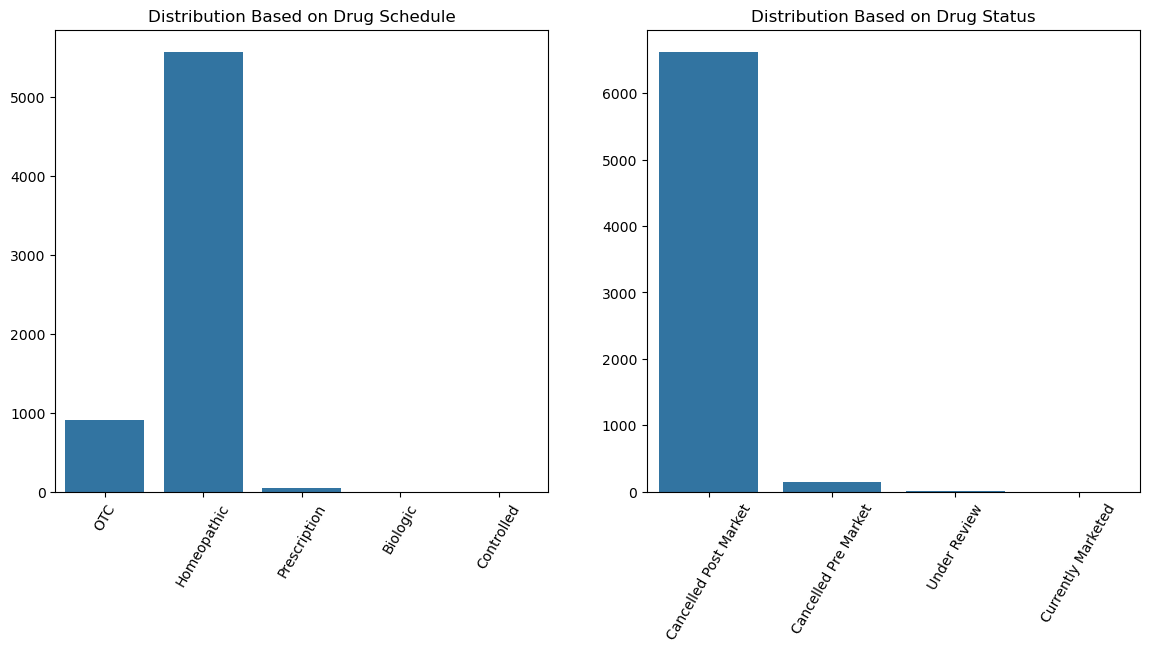

In [27]:
# Investigate why certain drug does not have a atc
drug_investigate = drug_merged[drug_merged['drug_code'].isin(q)].copy()

fig4, (ax4, ax5) = plt.subplots(ncols = 2, figsize = (14,6))
sns.countplot(ax=ax4, data=drug_investigate, x='schedule')
ax4.tick_params(axis='x', rotation = 60)
ax4.set_xlabel('')
ax4.set_ylabel('')
ax4.set_title('Distribution Based on Drug Schedule')

sns.countplot(ax=ax5, data=drug_investigate, x = 'status_grouped')
ax5.tick_params(axis='x', rotation = 60)
ax5.set_xlabel('')
ax5.set_ylabel('')
ax5.set_title('Distribution Based on Drug Status');

It is noted that most of the drug products without atc code belong to `Homeopathic` schedule, and most of them are cancelled post market. Further research online showed that after January 1<sup>st</sup>, 2024, natural health products (NHPs) started to be sold under a different category thanks to the establishment of Natural Health Products Regulations. These regulations were impletemented using a staged approach over the course of six years, from January 2004 to January 2010. Therefore, nowadays, all homepathic products are migrated under NHPs and thus therefore, all of the drugs belong to this schedule are cancelled post market. Thus, they will be dropped according to the current regulation.  

See [Health Canada: General Questions - Regulation of Natural Health Products](https://www.canada.ca/en/health-canada/services/drugs-health-products/natural-non-prescription/frequently-asked-questions/general-questions-regulation.html) for more information.

In [28]:
# Remove Homeopathic drugs and update query
drug_merged = drug_merged[(drug_merged['schedule']!='Homeopathic')].copy()
drug_investigate = drug_merged[drug_merged['drug_code'].isin(q)].copy()

Further research showed that drugs with multiple active ingredients are likely to have no atc code as atc code is assigned based on the therapeutic use and chemical classifiation of the compound. 

In [29]:
(drug_investigate['number_of_ais'] != '1').sum()
# Turned out not all drugs that is not recorded in drug_atc have more than 1 active compounds 
# But we can remove those drugs from the list as the reason for missing is found. 
drug_investigate.drop(drug_investigate[(drug_investigate['number_of_ais'] != '1')].index, inplace = True)
drug_investigate.shape # There are still 558 drugs with missing ATC code, and there is no found reasons for that. 

(558, 10)

Due to failure of finding reasons to account for missing ATC codes, where the ATC is missing will be replaced as `Missing`. There is also missing values in `schedule`. With failure of identifying the reason, these entries will unfortunately be dropped. 

In [30]:
# Merge ATC in + fill in missing by Missing
drug_merged_final = pd.merge(left = drug_merged, right = drug_atc_merged, how = 'left', on='drug_code')

def fill_na(df, col):
    return df[col].fillna('Missing')

missing = ['tc_atc', 'atc_2nd','atc_1st', 'Description_1st', 'Description_2nd']
for c in missing:
    drug_merged_final[c] = fill_na(drug_merged_final, c)

# Drop entries with missing schedule 
drug_merged_final.dropna(subset = 'schedule', inplace=True)

In [31]:
drug_merged_final[drug_merged_final.original_market_date.isna()]['status_grouped'].value_counts()

status_grouped
Under Review             3283
Cancelled Pre Market     2918
Cancelled Post Market     693
Currently Marketed          6
Name: count, dtype: int64

As mentioned before, there are several reasons that can account for a missing `original_market_date` when the drug status is `Cancelled Post Market`. However, for the purpose of this project, all drugs with a missing `original_market_date` will be treated as if they were never available. The only concern would be the 6 drugs that is currently marketed. Among 6 of them, 4 of them were under `Restricted Access`, and therefore, they could be as non-accessible at all time. 

In [32]:
drug_merged_final[(drug_merged_final.original_market_date.isna())&(drug_merged_final['status_grouped'] == 'Currently Marketed')]

,drug_code,class_name,brand_name,number_of_ais,company_name,aig,schedule,history_date,original_market_date,status_grouped,tc_atc,atc_2nd,atc_1st,Description_1st,Description_2nd
25597,78109,Human,CNJ-016,1,EMERGENT BIOSOLUTIONS CANADA INC.,52217,Biologic,2017-09-20,NaT,Currently Marketed,VACCINIA IMMUNOGLOBULIN,J06,J,ANTIINFECTIVES FOR SYSTEMIC USE,IMMUNE SERA AND IMMUNOGLOBULINS
37210,94692,Human,BAT,7,EMERGENT BIOSOLUTIONS CANADA INC.,58630,Biologic,2017-10-25,NaT,Currently Marketed,BOTULINUM ANTITOXIN,J06,J,ANTIINFECTIVES FOR SYSTEMIC USE,IMMUNE SERA AND IMMUNOGLOBULINS
37978,95839,Human,ANTHRASIL,1,EMERGENT BIOSOLUTIONS CANADA INC.,59650,Biologic,2018-09-26,NaT,Currently Marketed,ANTHRAX IMMUNOGLOBULIN,J06,J,ANTIINFECTIVES FOR SYSTEMIC USE,IMMUNE SERA AND IMMUNOGLOBULINS
38265,96286,Human,APO-TELMISARTAN-AMLODIPINE,2,APOTEX INC,52947,Prescription,2023-10-18,NaT,Currently Marketed,TELMISARTAN AND AMLODIPINE,C09,C,CARDIOVASCULAR SYSTEM,AGENTS ACTING ON THE RENIN-ANGIOTENSIN SYSTEM
38266,96287,Human,APO-TELMISARTAN-AMLODIPINE,2,APOTEX INC,52947,Prescription,2023-10-18,NaT,Currently Marketed,TELMISARTAN AND AMLODIPINE,C09,C,CARDIOVASCULAR SYSTEM,AGENTS ACTING ON THE RENIN-ANGIOTENSIN SYSTEM
39034,97381,Human,BIOTHRAX,1,EMERGENT BIODEFENSE OPERATIONS LANSING LLC,61010,Biologic,2019-03-20,NaT,Currently Marketed,ANTHRAX ANTIGEN,J07,J,ANTIINFECTIVES FOR SYSTEMIC USE,VACCINES


In [33]:
drug_merged_final.to_csv('Drug Final.csv')

In [35]:
drug_merged_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43373 entries, 0 to 43685
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   drug_code             43373 non-null  int64         
 1   class_name            43373 non-null  object        
 2   brand_name            43373 non-null  object        
 3   number_of_ais         43373 non-null  object        
 4   company_name          43373 non-null  object        
 5   aig                   43373 non-null  object        
 6   schedule              43373 non-null  object        
 7   history_date          43373 non-null  datetime64[ns]
 8   original_market_date  36473 non-null  datetime64[ns]
 9   status_grouped        43373 non-null  object        
 10  tc_atc                43373 non-null  object        
 11  atc_2nd               43373 non-null  object        
 12  atc_1st               43373 non-null  object        
 13  Description_1st      